# Data structures and frameworks: Advanced

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [1]:
import lamindb as ln
import spatialdata as sd

assert ln.setup.settings.instance.slug == "theislab/sc-best-practices"

→ connected lamindb: theislab/sc-best-practices


In [3]:
ln.track()

→ created Transform('mXw9HMEuQ9O10000'), started new Run('hT7fm0Nv...') at 2025-05-24 14:44:08 UTC
→ notebook imports: lamindb==1.5.3 mudata mudatasets muon scikit-learn==1.5.2 spatialdata==0.4.0 squidpy
• recommendation: to identify the notebook across renames, pass the uid: ln.track("mXw9HMEuQ9O1")


In [ ]:
data_path = "data.zarr"
sdata = sd.read_zarr(data_path)
sdata

/Users/luisheinzlmeier/miniconda3/envs/data_structures_and_frameworks_advanced/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


'introduction/data_structures_and_frameworks_advanced.zarr'

(at:mudata)=

## Advanced: Using MuData to store multimodal data

AnnData is primarily designed for storing and manipulating unimodal data. However, multimodal assays such as CITE-Seq generate multimodal data by simultaneously measuring RNA and surface proteins. This data requires more advanced ways of storing, which is where MuData comes into play. MuData builds on top of AnnData to store and manipulate multimodal data. muon{cite}`Bredikhin2022`, a "scanpy equivalent" and core package of scverse, can then be used to analyze the multimodal omics data.
The following section is based on the MuData Quickstart tutorial{cite}`mudata_quickstart` and the Multimodal data objects tutorial{cite}`mudata_object`.

:::{figure-md} mudata-fig
<img src="../_static/images/analysis_tools/mudata.png" alt="MuData Overview" class="bg-primary mb-1" width="800px">

MuData overview. Image obtained from {cite}`Bredikhin2022`.
:::

### Installation

MuData is available on PyPI and Conda can be installed with using either:
```bash
pip install mudata
conda install -c conda-forge mudata
```

The main idea behind MuData is that the MuData object contains references to the single AnnData objects of the unimodal data, but the MuData object itself also stores multimodal annotations. It is therefore possible to directly access the AnnData objects to perform unimodal data transformations which store their results in the corresponding AnnData annotations, but also to aggregate the modalities for joint calculations whose results can be stored in the global MuData object. Technically, this is realized by MuData objects comprising a dictionary with AnnData objects, one per modality, in their `.mod` (=modality) attribute. Just as AnnData objects themselves, they also contain attributes like `.obs` with annotation of observations (samples or cells), `.obsm` with their multidimensional annotations such as embeddings.

### Initializing a MuData object

We will start by importing MuData from the mudata package.

In [5]:
import mudata as md

ModuleNotFoundError: No module named 'mudata'

To create an example MuData object we require simulated data.

In [ ]:
n, d, k = 1000, 100, 10

z = np.random.default_rng().normal(
    loc=np.arange(k), scale=np.arange(k) * 2, size=(n, k)
)
w = np.random.default_rng().normal(size=(d, k))
y = np.dot(z, w.T)
y.shape

(1000, 100)

To create a MuData object we require the unimodal AnnData objects first. Therefore, we create two AnnData objects with *data for the same observations*, but for *different variables*.

In [44]:
adata = ad.AnnData(y)
adata.obs_names = [f"obs_{i+1}" for i in range(n)]
adata.var_names = [f"var_{j+1}" for j in range(d)]
adata

AnnData object with n_obs × n_vars = 1000 × 100

In [ ]:
d2 = 50
w2 = np.random.default_rng().normal(size=(d2, k))
y2 = np.dot(z, w2.T)

adata2 = ad.AnnData(y2)
adata2.obs_names = [f"obs_{i+1}" for i in range(n)]
adata2.var_names = [f"var2_{j+1}" for j in range(d2)]
adata2

AnnData object with n_obs × n_vars = 1000 × 50

These two AnnData objects (two "modalities") can then be wrapped into a single MuData object. Here, we name modality one `A` and modality two `B`.

In [46]:
mdata = md.MuData({"A": adata, "B": adata2})
mdata

MuData object with n_obs × n_vars = 1000 × 150
  2 modalities
    A:	1000 x 100
    B:	1000 x 50

Observations and variables of the MuData object are global, which means that observations with the identical name (`.obs_names`) in different modalities are considered to be the same observation. This also means variable names (`.var_names`) should be unique. This is reflected in the object description above: `mdata` has 1000 observations and 150 = 100+50 variables.

### MuData attributes

MuData objects consist of annotations as earlier described for AnnData objects like `.obs` or `.var`, but extend this behavior with `.mod` which serves as an accessor to the individual modalities.

Modalities are stored in a collection accessible via the `.mod` attribute of the MuData object with names of modalities as keys and AnnData objects as values.

In [47]:
list(mdata.mod.keys())

['A', 'B']

Individual modalities can be accessed with their names via the `.mod` attribute or via the MuData object itself as a shorthand.

In [48]:
print(mdata.mod["A"])
print(mdata["A"])

AnnData object with n_obs × n_vars = 1000 × 100
AnnData object with n_obs × n_vars = 1000 × 100


Samples (cells) annotation is accessible via the `.obs` attribute and by default includes copies of columns from `.obs` data frames of individual modalities. The same goes for `.var`, which contains annotation of variables (features). Observations columns copied from individual modalities contain modality name as their prefix, e.g. rna:n_genes. This is also true for variables columns. However if there are columns with identical names in `.var` of multiple modalities — e.g. n_cells, — these columns are merged across modalities and no prefix is added. When those slots are changed in AnnData objects of modalities, e.g. new columns are added or samples (cells) are filtered out, the changes have to be fetched with the `.update()` method (see below).

Multidimensional annotations of samples (cells) are accessible in the `.obsm` attribute. For instance, that can be UMAP coordinates that were learnt jointly on all modalities.

The MuData object’s shape is represented by two numbers calculated as a sum of the shapes of individual modalities — one for the number of observations and one for the number of variables.

In [49]:
print(mdata.shape)
print(mdata.n_obs)
print(mdata.n_vars)

(1000, 150)
1000
150


By default, variables are always counted as belonging uniquely to a single modality while observations with the same name are counted as the same observation, which has variables across multiple modalities measured for.

In [50]:
[adata.shape for adata in mdata.mod.values()]

[(1000, 100), (1000, 50)]

If the shape of a modality is changed, `MuData.update()` has to be run to bring the respective updates to the MuData object.

In [51]:
adata2.var_names = ["var_ad2_" + e.split("_")[1] for e in adata2.var_names]

In [52]:
print("Outdated variables names: ...,", ", ".join(mdata.var_names[-3:]))
mdata.update()
print("Updated variables names: ...,", ", ".join(mdata.var_names[-3:]))

Outdated variables names: ..., var2_48, var2_49, var2_50
Updated variables names: ..., var_ad2_48, var_ad2_49, var_ad2_50


Importantly, individual modalities are stored as references to the original objects. Hence, if the original AnnData is changed the change will also be reflected in the MuData object.

In [53]:
# Add some unstructured data to the original object
adata.uns["misc"] = {"adata": True}

In [54]:
# Access modality A via the .mod attribute
mdata.mod["A"].uns["misc"]

{'adata': True}

### Variable mappings

Upon construction of a MuData object, a global binary mapping between observations and individual modalities is created as well as between variables and modalities. Since all the observations are the same across modalities in `mdata`, all the values in the observations mappings are set to `True`.

In [55]:
np.sum(mdata.obsm["A"]) == np.sum(mdata.obsm["B"]) == n

True

For variables however, those are 150-long vectors. The `A` modality has 100 `True` values followed by 50 `False` values.

In [56]:
mdata.varm["A"]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

### MuData views

Analogous to the behavior of AnnData objects, slicing MuData objects returns views of the original data.

In [57]:
view = mdata[:100, :1000]
print(view.is_view)
print(view["A"].is_view)

True
True


Subsetting MuData objects is special since it slices them across modalities. I.e. the slicing operation for a set of `obs_names` and/or `var_names` will be performed for each modality and not only for the global multimodal annotation. This behavior makes workflows memory-efficient, which is especially important when working with large datasets. If the object is to be modified however, a copy of it should be created, which is not a view anymore and has no dependence on the original object.

In [58]:
mdata_sub = view.copy()
mdata_sub.is_view

False

### Common observations

While a MuData object is comprised of the same observations for both modalities, it is not always the case in the real world where some data might be missing. By design, MuData accounts for these scenarios since there’s no guarantee observations are the same — or even intersecting — for a MuData instance. It’s worth noting that other tools might provide convenience functions for some common scenarios of dealing with missing data, such as `intersect_obs()` implemented in muon.

### Reading and Writing of MuData objects


Similarly to AnnData objects, MuData objects were designed to be serialized into HDF5 based `.h5mu` files. All modalities are stored under their respective names in the `/mod` HDF5 group of the `.h5mu` file. Each individual modality, e.g. `/mod/A`, is stored in the same way as it would be stored in the `.h5ad` file. MuData objects can be read and written as follows:

In [59]:
mdata.write("my_mudata.h5mu")
mdata_r = md.read("my_mudata.h5mu", backed=True)
mdata_r

MuData object with n_obs × n_vars = 1000 × 150 backed at 'my_mudata.h5mu'
  2 modalities
    A:	1000 x 100
      uns:	'misc'
    B:	1000 x 50

Individual modalities are backed as well inside the `.h5mu` file.

In [60]:
mdata_r["A"].isbacked

True

If the original object is backed, the filename has to be provided to the `.copy()` call, and the resulting object will be backed at a new location.

In [61]:
mdata_sub = mdata_r.copy("mdata_sub.h5mu")
print(mdata_sub.is_view)
print(mdata_sub.isbacked)

False
True


### Multimodal methods

When the MuData object is prepared, it is up to multimodal methods to be used to make sense of the data. The most simple and naïve approach is to concatenate matrices from multiple modalities to perform for example dimensionality reduction.

In [62]:
x = np.hstack([mdata.mod["A"].X, mdata.mod["B"].X])
x.shape

(1000, 150)

We can write a simple function to run principal component analysis on such a concatenated matrix. MuData object provides a place to store multimodal embeddings: MuData`.obsm`. It is similar to how the embeddings generated on individual modalities are stored, only this time it is saved inside the MuData object rather than in AnnData`.obsm`.

To calculate for example a principal component analysis (PCA) for the joint values of the modalities, we horizontally stack the values stored in the individual modalities and then perform the PCA on the stacked matrix. This is possible because the number of observations matches across modalities (remember, the number of features per modality does not have to match).

In [63]:
def simple_pca(mdata):
    from sklearn import decomposition

    x = np.hstack([m.X for m in mdata.mod.values()])

    pca = decomposition.PCA(n_components=2)
    components = pca.fit_transform(x)

    # By default, methods operate in-place and embeddings are stored in the .obsm slot
    mdata.obsm["X_pca"] = components

In [64]:
simple_pca(mdata)
print(mdata)

MuData object with n_obs × n_vars = 1000 × 150
  obsm:	'X_pca'
  2 modalities
    A:	1000 x 100
      uns:	'misc'
    B:	1000 x 50


Our calculated principal components are now stored in the MuData object itself and accessible for further multimodal transformations.

In reality, however, having different modalities often means that the features between them come from different generative processes and are not comparable. This is where special multimodal integration methods come into play. For omics technologies, these methods are frequently addressed as multi-omics integration methods. In the following section we will introduce muon which provides many tools to preprocess unimodal data beyond RNA-Seq and multi-omics integration methods.

## Advanced: Multimodal data analysis with muon

Although scanpy provides generally applicable tools such as PCA, UMAP, and various visualizations, it is primarily designed to analyze RNA-Seq data.
Muon fills this gap by providing preprocessing functions for other omics, such as chromatin accessibility (ATAC) or protein (CITE) data.
As mentioned above, muon further provides algorithms to run multi-omics algorithms that infer knowledge from the joint modalities.
For example, users may run a PCA on a single modality, but muon further provides multi-omics factor analysis algorithms that take several modalities as input.

:::{figure-md} muon-fig
<img src="../_static/images/analysis_tools/muon.png" alt="muon Overview" class="bg-primary mb-1" width="800px">

muon overview. Image obtained from {cite}`Bredikhin2022`.
:::

### Installation

Muon (as well as mudatasets) is available on Python Package Index (PyPI) can be installed using:
```bash
pip install muon
pip install mudatasets
```

### API overview

To introduce muon, we will examine the ATAC data from a multimodal dataset.
Analogously to the scanpy chapter, this chapter solely serves as a quick demo and overview of muon and does not analyze a dataset thoroughly, let alone provide best-practice multi-omics analysis.
Please read the corresponding chapters to learn how to properly conduct such analyses.

Muon separates its modules in two ways. First, analogously to scanpy, general and multimodal functions are grouped in preprocessing (`muon.pp`), tools (`muon.tl`) and plots (`muon.pl`).
Second, unimodal tools are available from the corresponding muon, which are again separated into preprocessing, tools and plots. 
For example, all ATAC preprocessing functions are grouped into `muon.atac.pp`.
This also applies to CITE-Seq preprocessing functions (`muon.prot.pp`).

:::{figure-md} muon-api
<img src="../_static/images/analysis_tools/muon_api.png" alt="muon API Overview" class="bg-primary mb-1" width="800px">

muon API overview. Modality specific functions are provided in correspondingly named modules. Functions for the joint analysis of modalities are available via the muon module directly.
:::

### muon API demo

The dataset for our demo is a publicly available 10x Genomics Multiome dataset for human PBMCs. Let us import muon and get the dataset with mudatasets.

In [ ]:
import mudatasets as mds
import muon as mu

In [66]:
mdata, _ = mds.load("pbmc10k_multiome", with_info=True, full=True)
mdata.var_names_make_unique()

■ File filtered_feature_bc_matrix.h5 from pbmc10k_multiome has been found at /home/zeth/mudatasets/pbmc10k_multiome/filtered_feature_bc_matrix.h5
■ Checksum is validated (md5) for filtered_feature_bc_matrix.h5
■ File atac_fragments.tsv.gz from pbmc10k_multiome has been found at /home/zeth/mudatasets/pbmc10k_multiome/atac_fragments.tsv.gz
■ Checksum is validated (md5) for atac_fragments.tsv.gz
■ File atac_fragments.tsv.gz.tbi from pbmc10k_multiome has been found at /home/zeth/mudatasets/pbmc10k_multiome/atac_fragments.tsv.gz.tbi
■ Checksum is validated (md5) for atac_fragments.tsv.gz.tbi
■ File atac_peaks.bed from pbmc10k_multiome has been found at /home/zeth/mudatasets/pbmc10k_multiome/atac_peaks.bed
■ Checksum is validated (md5) for atac_peaks.bed
■ File atac_peak_annotation.tsv from pbmc10k_multiome has been found at /home/zeth/mudatasets/pbmc10k_multiome/atac_peak_annotation.tsv
■ Checksum is validated (md5) for atac_peak_annotation.tsv
■ Loading filtered_feature_bc_matrix.h5...


/home/zeth/miniconda3/envs/bp2/lib/python3.9/site-packages/mudatasets/core.py:203: UserWarning: Dataset is in the 10X .h5 format and can't be loaded as backed.
  warn("Dataset is in the 10X .h5 format and can't be loaded as backed.")
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added `interval` annotation for features from /home/zeth/mudatasets/pbmc10k_multiome/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added peak annotation from /home/zeth/mudatasets/pbmc10k_multiome/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: /home/zeth/mudatasets/pbmc10k_multiome/atac_fragments.tsv.gz


As a first step we subset to the ATAC modality.

In [67]:
atac = mdata.mod["atac"]

Although, we are now not working with RNA-Seq, it is possible to use some of scanpy's preprocessing functions which can also be used on ATAC data. This is possible due to similar distribution and quality issues of both modalities. The only thing to bear in mind here that a gene would mean a peak in the context of the AnnData object with ATAC-seq data. Afterwards, ATAC specific preprocessing can be conducted with the ATAC module of muon.

Let us start with some quality control by filtering out cells with too few peaks and peaks detected in too few cells. For now, we will filter out cells that do not pass QC.

In [68]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

/home/zeth/miniconda3/envs/bp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/home/zeth/miniconda3/envs/bp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


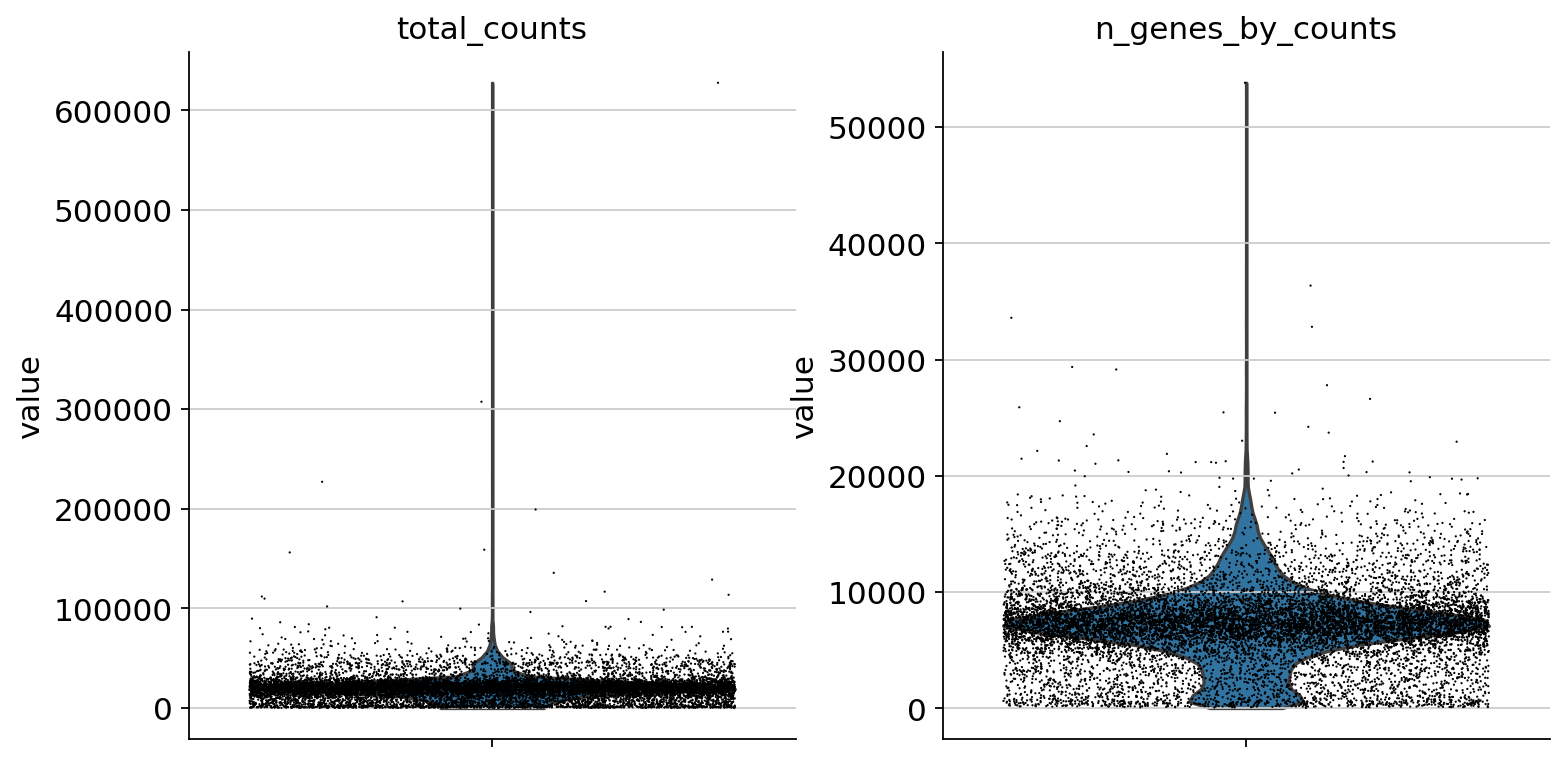

In [69]:
sc.pl.violin(atac, ["total_counts", "n_genes_by_counts"], jitter=0.4, multi_panel=True)

Filter peaks whose expression is not detected.

In [70]:
mu.pp.filter_var(atac, "n_cells_by_counts", lambda x: x >= 10)
# This is analogous to
#   sc.pp.filter_genes(rna, min_cells=10)
# but does in-place filtering and avoids copying the object

We also filter the cells.

In [71]:
mu.pp.filter_obs(atac, "n_genes_by_counts", lambda x: (x >= 2000) & (x <= 15000))
# This is analogous to
#   sc.pp.filter_cells(atac, max_genes=15000)
#   sc.pp.filter_cells(atac, min_genes=2000)
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(atac, "total_counts", lambda x: (x >= 4000) & (x <= 40000))

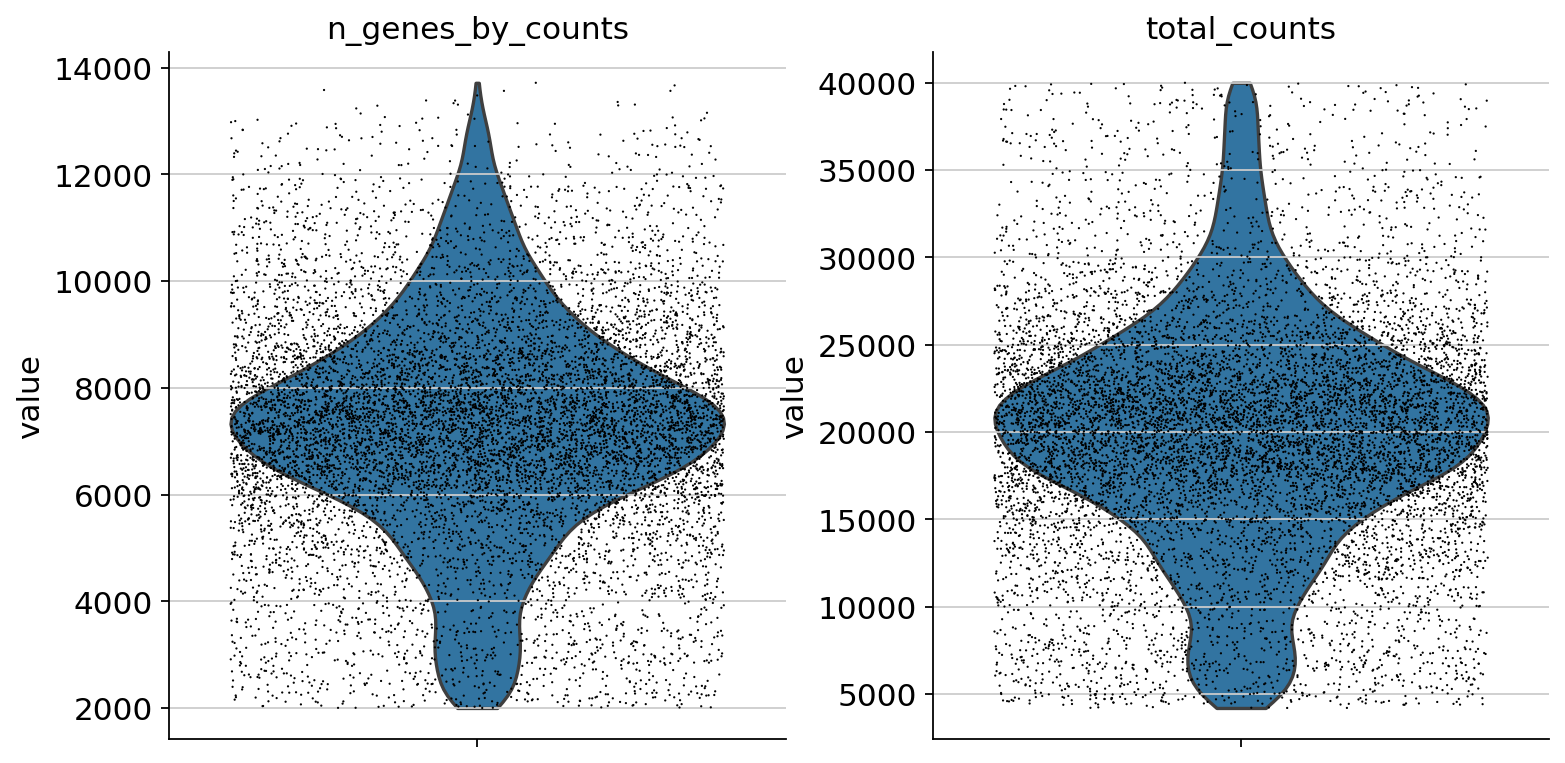

In [72]:
sc.pl.violin(atac, ["n_genes_by_counts", "total_counts"], jitter=0.4, multi_panel=True)

muon also provides histograms which allows for a different view on the metrics.

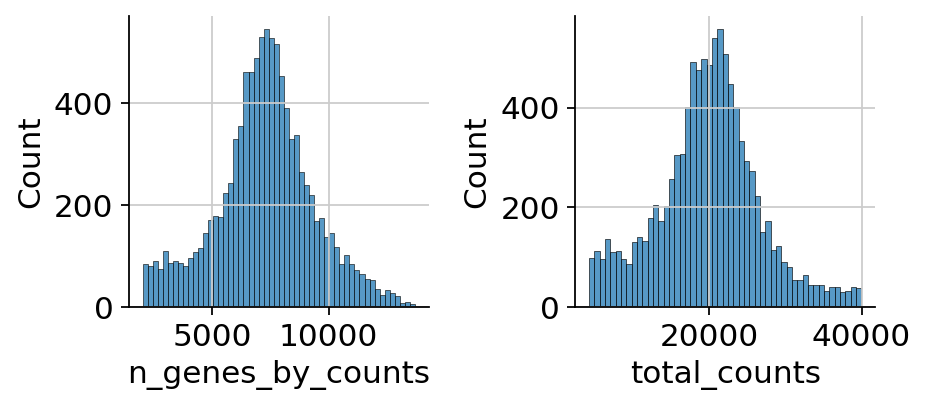

In [73]:
mu.pl.histogram(atac, ["n_genes_by_counts", "total_counts"])

Now that we rudimentary filtered out cells with too few peaks and peaks detected in too few cells, we can start with ATAC specific quality control with muon. muon has modality specific preprocessing functions in corresponding modules. We import the ATAC module to access the ATAC specific preprocessing functions.

In [74]:
from muon import atac as ac

Fetching Regions...: 100%|██████████| 1000/1000 [00:19<00:00, 50.03it/s]


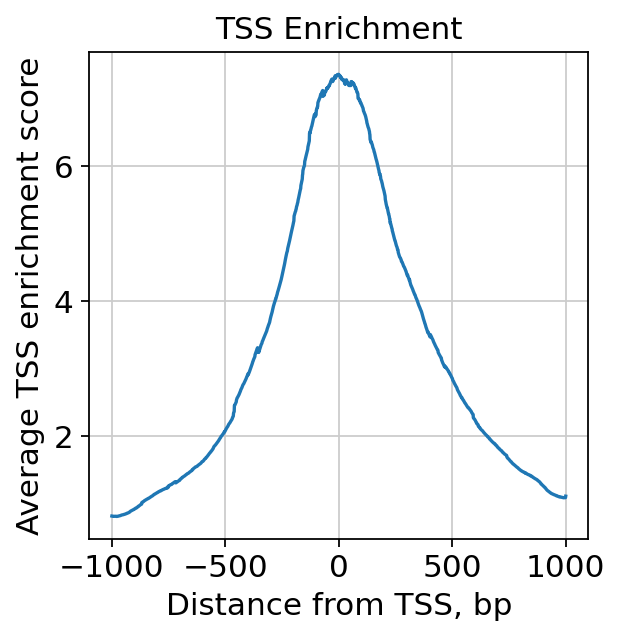

In [75]:
# Perform rudimentary quality control with muon's ATAC module
atac.obs["NS"] = 1
ac.tl.nucleosome_signal(atac, n=1e6)
ac.tl.get_gene_annotation_from_rna(mdata["rna"]).head(3)
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)
ac.pl.tss_enrichment(tss)

In [76]:
# Save original counts, normalize data and select highly variable genes with scanpy
atac.layers["counts"] = atac.X
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=0.5)
atac.raw = atac

Although PCA is also commonly used for ATAC data, latent semantic indexing (LSI) is another popular option. It is implemented in muon's ATAC module.

In [77]:
ac.tl.lsi(atac)

In [78]:
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

In [79]:
sc.tl.leiden(atac, resolution=0.5)

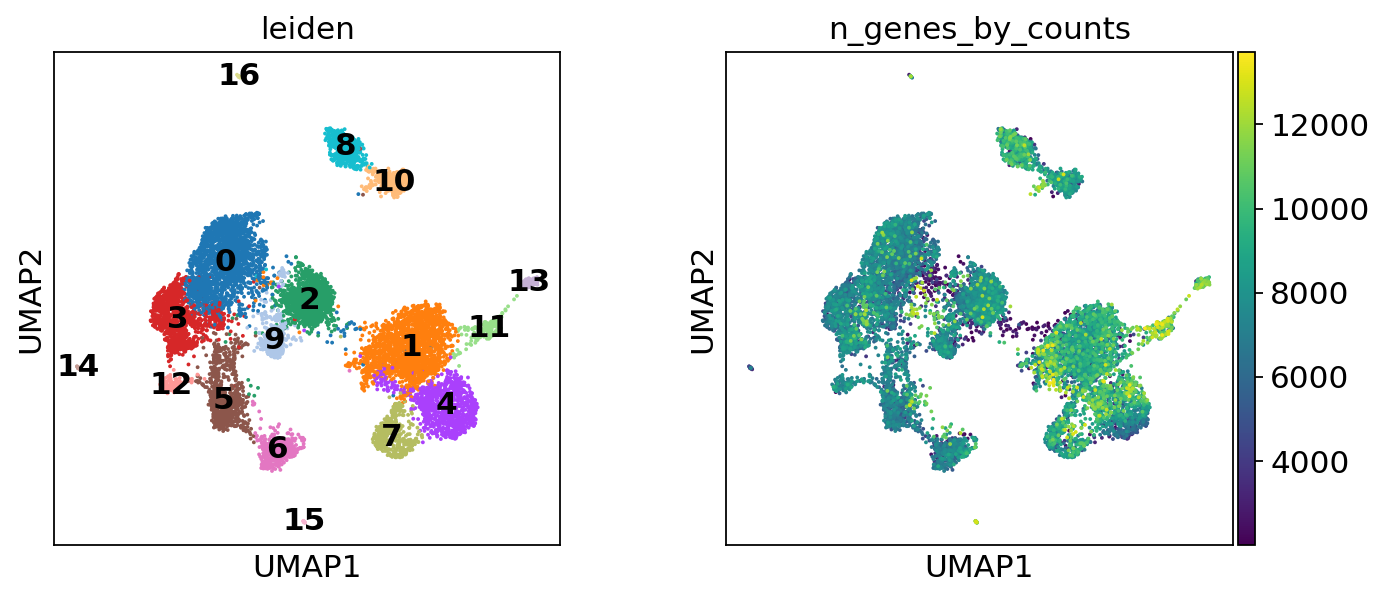

In [80]:
sc.tl.umap(atac, spread=1.5, min_dist=0.5, random_state=20)
sc.pl.umap(atac, color=["leiden", "n_genes_by_counts"], legend_loc="on data")

We can use the functionality of the ATAC module in muon to color plots by cut values in peaks corresponding to a certain gene.

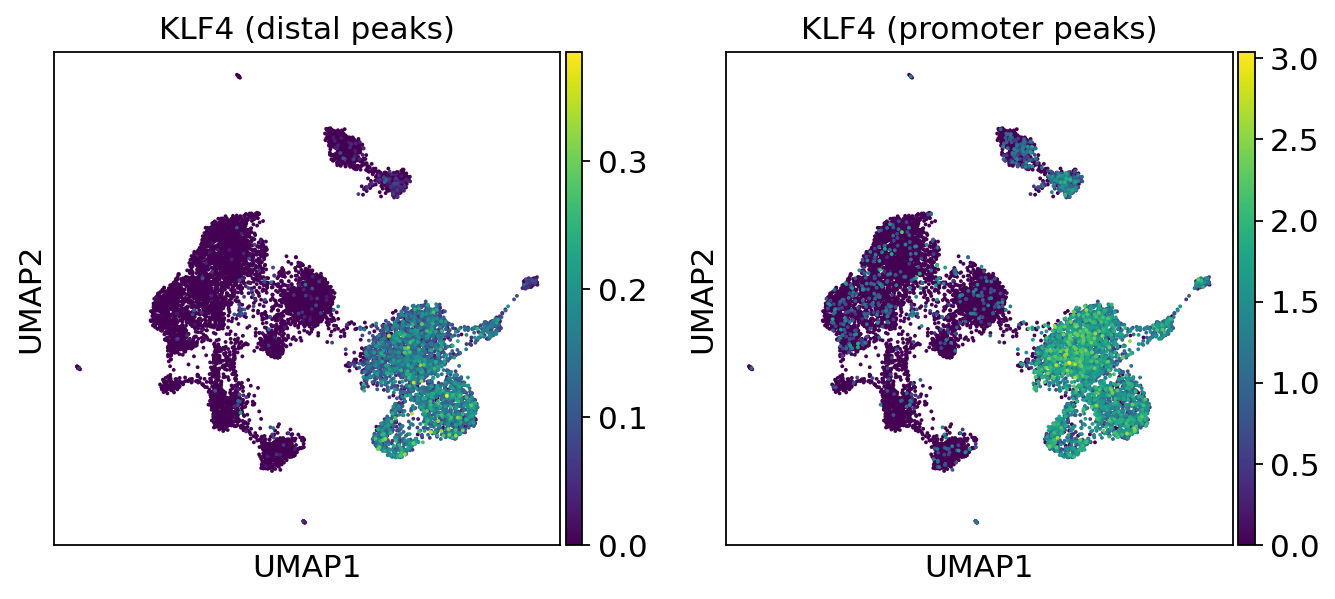

In [81]:
ac.pl.umap(atac, color=["KLF4"], average="peak_type")

For more details on all available functions of muon, please read the muon API reference at https://muon.readthedocs.io/en/latest/api/index.html and the muon tutorials at https://muon-tutorials.readthedocs.io/en/latest/.

## Advanced: Using SpatialData to store multimodal and spacial data

In the analogy of the scverse, SpacialData provides the data structure for loading, manipulating and storing spatial omics data. 
SpatialData establishes a standardized, extensible multiplatform file format that supports lazy representation of larger-than-memory data, enabling efficient data transformations and alignment to common coordinate systems. This framework facilitates spatial annotations and cross-modal aggregation, making it an invaluable tool for integrative analysis.
The SpatialData framework is built on five core primitive elements—Images, Labels, Points, Shapes, and Tables—which collectively represent raw and derived data from a wide range of spatial omics technologies.
These elements are serialized in a Zarr store, compliant with the Open Microscopy Environment–Next-Generation File Format (OME–NGFF), ensuring interoperability and efficient access across both traditional file systems and cloud-based storage.
The accompanying SpatialData Python library provides a unified programmatic interface for accessing, manipulating, and analyzing spatial datasets. It supports lazy loading of data, enabling the handling of datasets that exceed memory capacity, and offers versatile functionalities for defining coordinate transformations, querying datasets, and performing cross-modal aggregations. Additionally, SpatialData integrates seamlessly with the broader Python ecosystem, including tools like Scanpy, Squidpy, and scvi-tools, and supports interactive data exploration and annotation through the napari-spatialdata plugin.

In the scverse ecosystem, SpatialData serves as the foundational data structure for managing spatial omics data. It introduces a standardized, extensible file format that supports lazy representation of larger-than-memory datasets, enabling efficient transformations and alignment to common coordinate systems. This framework streamlines spatial annotations and cross-modal aggregation, making it essential for integrative analysis.

SpatialData organizes data into five core elements—Images, Labels, Points, Shapes, and Tables—representing raw and derived data from diverse spatial omics technologies. These elements are serialized in a Zarr store, compliant with the Open Microscopy Environment–Next-Generation File Format (OME–NGFF), ensuring interoperability and efficient access across file systems and cloud storage.

The accompanying SpatialData Python library provides a unified interface for accessing, manipulating, and analyzing spatial datasets. It supports lazy loading for memory-efficient handling of large datasets and offers tools for coordinate transformations, dataset querying, and cross-modal aggregation. Seamlessly integrated with the Python ecosystem—including tools like Scanpy, Squidpy, and scvi-tools—it also enables interactive exploration and annotation via the napari-spatialdata plugin.



We adapted the following section from 


### Installation and importing
Again, either use PyPI or Conda to install SpacialData.
```bash
pip install spatialdata
conda install -c conda-forge spatialdata
```



### Key terms and data model
We can think of a `SpatialData` object as a container for various `Elements`. An `Element` is either a `SpatialElement` (`Images`, `Labels`, `Points`, `Shapes`) or a `Table`. Here is a brief description:
- `Images`: H&E, staining images
- `Labels`: pixel-level segmentation
- `Points`: transcripts locations with gene information, landmarks points
- `Shapes`: cell/nucleus boundaries, subcellular structures, anatomical annotations, regions of interest (ROIs)
- `Tables`: sparse/dense matrices annotating the the `SpatialElements` or storing arbitrary (non-spatial) metadata. They do not contain spatial coordinates.

We can categorize the `SpatialElements` into two broad types:
- `Rasters`: Data made up of pixels: including `Images` and `Labels`
- `Vectors`: Data made up of points and lines. Polygons are also vectors, since they are a simply a list of connected points. `Points` and `Shapes` are elements of this type.

:::{figure-md} spacialdata-fig
<img src="../_static/images/analysis_tools/SpacialData_elements.png" alt="Overview of SpacialData's elements" max-width = 800px>

The elements of a SpacialData object. Obtained from .
:::



In [4]:
import spatialdata as sd
import spatialdata_plot  # noqa: F401

```{error}
:class: dropdown

If you are having problems with dask like mentioned in this [issue](https://github.com/dask/dask/issues/11146) you have to change dask to an older version. Versions >2024.11.2 won't work anymore.

```bash
pip uninstall dask dask-expr -y
pip install "dask[dataframe]==2024.11.2" dask-expr

conda remove dask dask-expr -y
conda install dask==2024.11.2 dask-expr -c conda-forge

conda install dask==2024.11.2 -c conda-forge
```

For 3.11.11

```bash
pip install numba==0.59.1
```

```

On disc, `SpatialData` objects are stored in the SpatialData [Zarr](https://zarr.dev/) format. 

This dataset comes from 
[here](https://s3.embl.de/spatialdata/spatialdata-sandbox/mouse_liver.zip)
 for on-disk storage
The mouse liver dataset we load with `lamindb` comes from here.

In [13]:
af = ln.Artifact.get("95no3ylux2ltRF760000")
sdata = af.load()
sdata

/Users/luisheinzlmeier/miniconda3/envs/data_structures_and_frameworks_advanced/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: /Users/luisheinzlmeier/Library/Caches/lamindb/lamin-eu-central-1/VPwcjx3CDAa2/introduction/data_structures_and_frameworks_advanced_spatialdata.zarr
├── Images
│     └── 'raw_image': DataTree[cyx] (1, 6432, 6432), (1, 1608, 1608)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (6432, 6432)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     └── 'nucleus_boundaries': GeoDataFrame shape: (3375, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (3375, 99)
with coordinate systems:
    ▸ 'global', with elements:
        raw_image (Images), segmentation_mask (Labels), transcripts (Points), nucleus_boundaries (Shapes)

### Explore the `Elements` of the `SpatialData` object

Let's explore each element type and how they are represented:
- Images: [`xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html) or [`xarray.DataTree`](https://docs.xarray.dev/en/stable/generated/xarray.DataTree.html) objects respectively for single-scale or multi-scale images
- Labels: [`xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html) or [`xarray.DataTree`](https://docs.xarray.dev/en/stable/generated/xarray.DataTree.html) objects containing integer codes for different labels
- Points: [`dask.DataFrame`](https://docs.dask.org/en/stable/dataframe.html) objects containing point coordinates, (lazy version of [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) objects)
- Shapes: [`geopandas.GeoDataFrame`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html) objects containing geometric objects like polygons
- Tables: [`anndata.AnnData`](https://anndata.readthedocs.io/en/stable/generated/anndata.AnnData.html) objects for tabular data with annotations


<a id = code-cell></a>

In [29]:
sdata["raw_image"]

<xarray.DataTree>
Group: /
├── Group: /scale0
│       Dimensions:  (c: 1, y: 6432, x: 6432)
│       Coordinates:
│         * c        (c) int64 8B 0
│         * y        (y) float64 51kB 0.5 1.5 2.5 3.5 ... 6.43e+03 6.43e+03 6.432e+03
│         * x        (x) float64 51kB 0.5 1.5 2.5 3.5 ... 6.43e+03 6.43e+03 6.432e+03
│       Data variables:
│           image    (c, y, x) uint16 83MB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
└── Group: /scale1
        Dimensions:  (c: 1, y: 1608, x: 1608)
        Coordinates:
          * c        (c) int64 8B 0
          * y        (y) float64 13kB 2.0 6.0 10.0 14.0 ... 6.422e+03 6.426e+03 6.43e+03
          * x        (x) float64 13kB 2.0 6.0 10.0 14.0 ... 6.422e+03 6.426e+03 6.43e+03
        Data variables:
            image    (c, y, x) uint16 5MB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>

Images can have multiple scales, which are stored in a pyramid for downsampled representations useful for more efficient visualization and analysis. 
We can access a single scale using the `get_pyramid_levels` function, where `0` is the highest resolution, `1` is downsampled by a factor of (usually 2), `2` is downsampled by another factor (usually 2, with respect to the previous scale), etc.

In this case, our image has 2 scales (check out groups of the output from the code cell [above](code-cell)). Let's access the highest resolution image.

In [30]:
sd.get_pyramid_levels(sdata["raw_image"], n=1)

<xarray.DataArray 'image' (c: 1, y: 1608, x: 1608)> Size: 5MB
dask.array<from-zarr, shape=(1, 1608, 1608), dtype=uint16, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 8B 0
  * y        (y) float64 13kB 2.0 6.0 10.0 14.0 ... 6.422e+03 6.426e+03 6.43e+03
  * x        (x) float64 13kB 2.0 6.0 10.0 14.0 ... 6.422e+03 6.426e+03 6.43e+03
Attributes:
    transform:  {'global': Sequence \n    Scale (y, x)\n        [4. 4.]\n    ...

To view image properties such as axes and channel names, `SpatialData` provides some helper functions.
More helper functions can be found in the [API](https://spatialdata.scverse.org/en/stable/api.html) page.
The axes `x` and `y` represent the two-dimensional plane of the image, while `c` corresponds to the different channels (e.g., wavelength) within the image.

In [31]:
sd.models.get_axes_names(sdata["raw_image"])

('c', 'y', 'x')

Here we see that our image only has one channel for DAPI staining (highlights nucleus).

In [32]:
sd.models.get_channel_names(sdata["raw_image"])

[np.int64(0)]

Let's use `spatialdata-plot` to show the image (DAPI staining for nuclei).

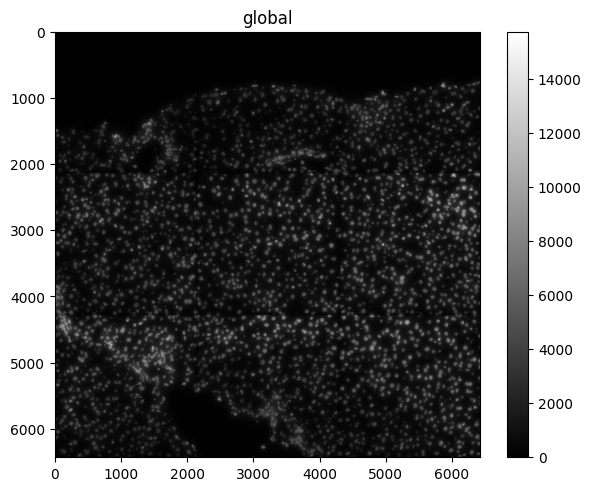

In [33]:
sdata.pl.render_images("raw_image", cmap="gray").pl.show()

### Points

Points are represented as `dask.DataFrame` objects containing point coordinates (lazy version of `pandas.DataFrame` objects).
Lazy-loading the `DataFrame` reduces memory usage, as the information is only retrieved from the data file when it is needed and not all at once.
For spatial transcriptomics datasets measuring single-molecules, coordinates are stored in columns `x` and `y` (optionally `z` for 3D) and have an additional column annotating gene identity.

In [35]:
sdata["transcripts"]

,x,y,gene
npartitions=1,,,
,float64,float64,category[unknown]
,...,...,...


We can easily convert the `dask.DataFrame` to a `pandas.DataFrame` using `.compute()` so it is easier to work with.
Note that this will load the entire object into memory.
If the data is large you can used directly the `dask` APIs for the manipulation of the dataframe.

In [10]:
sdata["transcripts"].compute()

,x,y,gene
0,433.0,1217.0,Adgre1
1,151.0,1841.0,Adgre1
2,139.0,1983.0,Adgre1
3,1349.0,1601.0,Adgre1
4,784.0,1732.0,Adgre1
...,...,...,...
1998863,5743.0,5233.0,Lyve1
1998864,5721.0,4581.0,Lyve1
1998865,5807.0,4842.0,Lyve1
1998866,5843.0,5309.0,Lyve1


Let's visualize the points.
Note that plotting automatically switches from `matplotlib` to `datashader` when the number of points is large, ensuring performant rendering.
As you can see below, it will be more useful to plot subsets of transcripts, such as specific genes.

Let's plot the transcripts colored by gene.
We can also use the `groups` argument to plot transcripts for a subset of genes.

/Users/luisheinzlmeier/miniconda3/envs/data_structures_and_frameworks_advanced/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/luisheinzlmeier/miniconda3/envs/data_structures_and_frameworks_advanced/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/Users/luisheinzlmeier/miniconda3/envs/data_structures_and_frameworks_advanced/lib/python3.12/site-packages/spatialdata/_core/_elements.py:115: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/luisheinzlmeier/miniconda3/envs/data_structures_and_frameworks_advanced/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/luisheinzlmeier/miniconda3/envs/data_structures_and_frameworks_advanced/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/luisheinzlmeier/miniconda3/envs/data_structures_and_frameworks_advanced/lib/python3.12/site-packages/spatialdata/_core/_elements.py:115: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  s

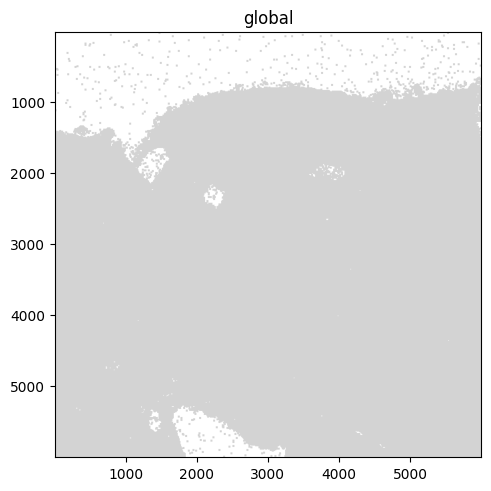

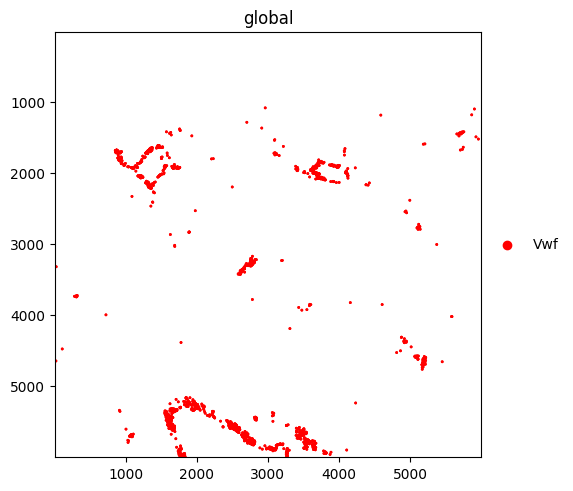

In [36]:
sdata.pl.render_points("transcripts").pl.show()
sdata.pl.render_points(
    "transcripts", color="gene", groups="Vwf", palette="red"
).pl.show()

### Shapes

Shapes are represented as `geopandas.GeoDataFrame` objects containing geometric objects like polygons.
For a comprehensive guide on working with `geopandas.GeoDataFrame` objects, please refer to the [`geopandas` documentation](https://geopandas.org/en/stable/docs.html).

In [38]:
sdata["nucleus_boundaries"]

,geometry
cell_ID,
99,"POLYGON ((6277 798, 6277 799, 6272 799, 6272 8..."
142,"POLYGON ((6427 6123, 6423 6123, 6423 6124, 641..."
208,"POLYGON ((3747 858, 3747 859, 3746 859, 3746 8..."
235,"POLYGON ((752 6144, 752 6145, 763 6145, 763 61..."
336,"POLYGON ((5174 935, 5174 936, 5172 936, 5172 9..."
...,...
7652,"POLYGON ((1094 6028, 1094 6029, 1091 6029, 109..."
7680,"POLYGON ((1324 6063, 1324 6064, 1320 6064, 132..."
7694,"POLYGON ((1692 6063, 1692 6064, 1686 6064, 168..."


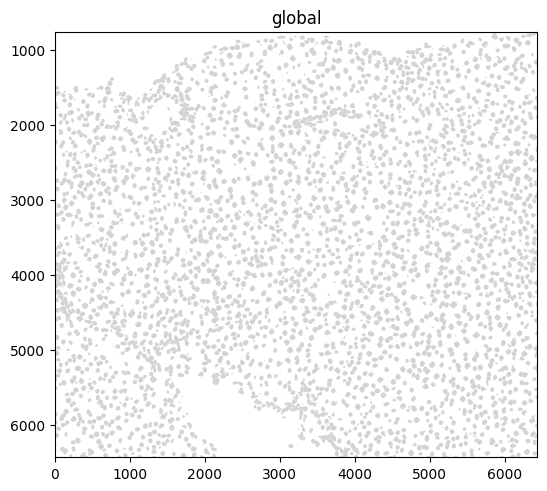

In [39]:
sdata.pl.render_shapes("nucleus_boundaries").pl.show()

### Tables

Annotated matrices are represented as `anndata.AnnData` objects.
Ingested datasets will usually have a table located at `sdata['table']` for a count/abundance matrix.
This enables downstream analysis with tools like Scanpy, scVI, etc.

For different spatial technologies this quantifies:
- transcriptomics: transcript counts;
- spatial proteomics: marker abundances;
- slide-based assays: spot/grid abundances ([see spatial chapter](../spatial/introduction.ipynb)).

In [40]:
sdata["table"]

AnnData object with n_obs × n_vars = 3375 × 99
    obs: 'cell_ID', 'fov_labels', 'annotation'
    uns: 'annotation_colors', 'spatialdata_attrs'
    obsm: 'spatial'

Here is an example of plotting numerical information on the cells ("Hal" gene expression).
Now is an example of plotting categorical information (cell types).

/Users/luisheinzlmeier/Desktop/Helmholtz/single-cell-best-practices/jupyter-book/introduction/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `nucleus_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/luisheinzlmeier/Desktop/Helmholtz/single-cell-best-practices/jupyter-book/introduction/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/luisheinzlmeier/Desktop/Helmholtz/single-cell-best-practices/jupyter-book/introduction/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `nucleus_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/luisheinzlmeier/Desktop/Helmholtz/single-cell-best-practices/jupyter-book/introduction/.venv/lib/python3.1

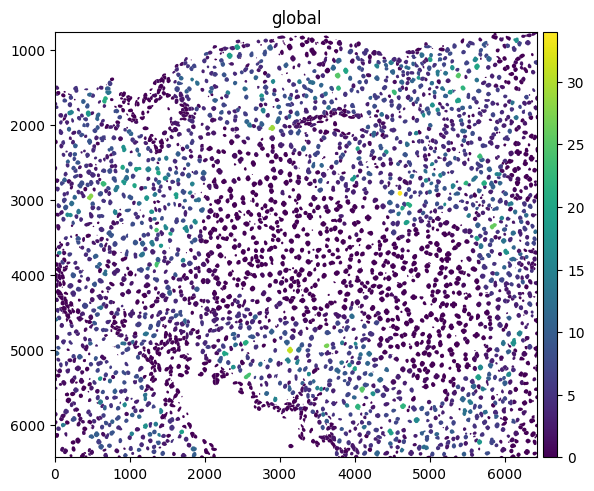

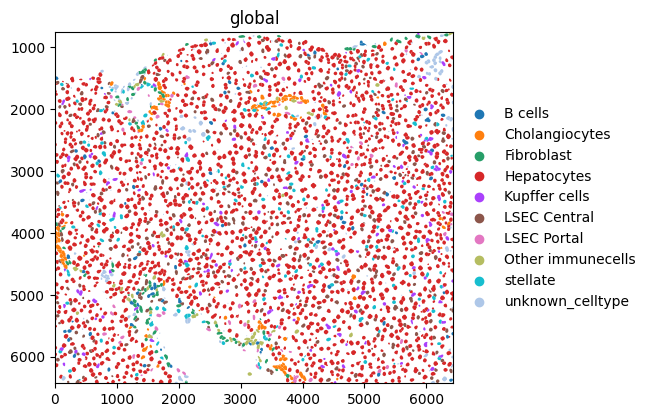

In [ ]:
sdata.pl.render_shapes("nucleus_boundaries", color="Hal").pl.show()
sdata.pl.render_shapes("nucleus_boundaries", color="annotation").pl.show()

## Spacial omics data analysis with squidpy

Squidpy is a tool to analyze and visualize spatial omics data.
It was published around two years before SpatialData {cite}`Marconato2025, Palla2022`.
This is also why squidpy was originally builts on top of scanpy and anndata.
We adopted the following section from spatialdata's tutorial "[squidpy integration](https://spatialdata.scverse.org/en/stable/tutorials/notebooks/notebooks/examples/squidpy_integration.html)".
As the scverse ecosystem will gradually transition squidpy to use spatialdata internally, this only gives a short introduction on how squidpy uses spatial data.
Check out future changes and tutorials on the documentation of [spatialdata](https://spatialdata.scverse.org/en/stable/index.html) and [squidpy](https://spatialdata.scverse.org/en/stable/index.html).


### Installation and importing packages
```bash
pip install squidpy
```

### SpacialData integration
Let`s start by importing squidpy.

In [45]:
import squidpy as sq

/Users/luisheinzlmeier/miniconda3/envs/data_structures_and_frameworks_advanced/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


We can load a Xenium dataset with `lamindb`.

In [43]:
af = ln.Artifact.get("b1RDFMMW8H5hVbzP0000")
sdata = af.load()
sdata

/Users/luisheinzlmeier/miniconda3/envs/data_structures_and_frameworks_advanced/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/luisheinzlmeier/miniconda3/envs/data_structures_and_frameworks_advanced/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object, with associated Zarr store: /Users/luisheinzlmeier/Library/Caches/lamindb/lamin-eu-central-1/VPwcjx3CDAa2/introduction/data_structures_and_frameworks_advanced_squidpy.zarr
├── Images
│     ├── 'morphology_focus': DataTree[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
│     └── 'morphology_mip': DataTree[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
│     └── 'cell_circles': GeoDataFrame shape: (167780, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (167780, 313)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), morphology_mip (Images), transcripts (Points), cell_boundaries (Shapes), cell_circles (Shapes)

### Squidpy demo

Let's compute a nearest neighbor graph of the spatial coordiantes of the xenium dataset.

In [44]:
sq.gr.spatial_neighbors(sdata["table"])

NameError: name 'sq' is not defined

After that, we can cluster the cells based on gene expression profiles and compute clustering.

In [ ]:
%%time
sc.pp.pca(sdata["table"])
sc.pp.neighbors(sdata["table"])
sc.tl.leiden(sdata["table"])

/opt/miniconda3/envs/ome/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<timed exec>:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


CPU times: user 1min 12s, sys: 1.69 s, total: 1min 14s
Wall time: 1min 14s


And run the neighbor enrichment analysis in squidpy.

100%|█████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.25/s]
/opt/miniconda3/envs/ome/lib/python3.10/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: divide by zero encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)
/opt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/ome/lib/python3.10/site-packages/squidpy/pl/_utils.py:555: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]
/opt/miniconda3/envs/ome/lib/python3.10/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step


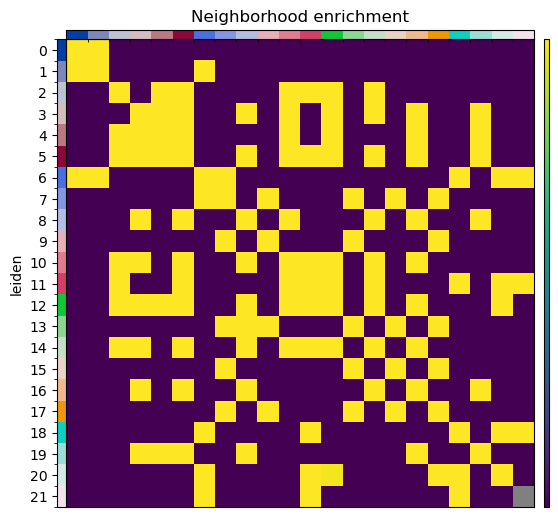

In [ ]:
sq.gr.nhood_enrichment(sdata["table"], cluster_key="leiden")
sq.pl.nhood_enrichment(sdata["table"], cluster_key="leiden", figsize=(5, 5))

We can finally visualize the results in spatial coordinates both with squidpy as well as with the novel plotting function in spatialdata.


CPU times: user 118 ms, sys: 7.58 ms, total: 125 ms
Wall time: 125 ms


/opt/miniconda3/envs/ome/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


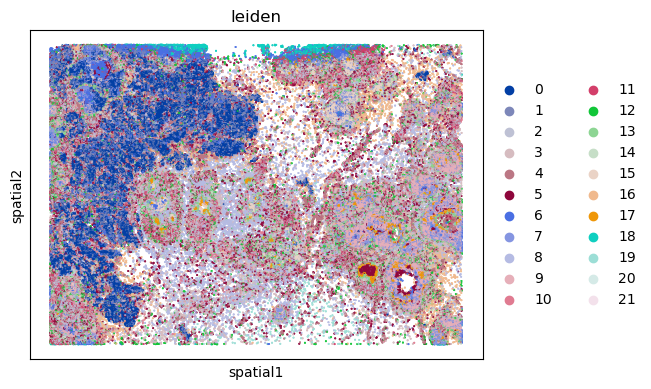

In [ ]:
%%time
sq.pl.spatial_scatter(sdata["table"], shape=None, color="leiden")

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: at
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Lukas Heumos
* Luis Heinzmeier

### Reviewers

* Isaac Virshup